In [49]:
from scipy.spatial.distance import squareform, pdist, cdist
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.stats import hypergeom
from goatools import obo_parser
from functools import partial

import os
import time
import graco
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [50]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)


DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/individual_clusters"

if not os.path.exists(DATA_DIRECTORY):
    os.makedirs(DATA_DIRECTORY)
        
if not os.path.exists(RAW_DATA_DIRECTORY):
    os.makedirs(RAW_DATA_DIRECTORY)
    
if not os.path.exists(PPI_DIRECTORY):
    os.makedirs(PPI_DIRECTORY)
    
if not os.path.exists(ANNOTATIONS_DIRECTORY):
    os.makedirs(ANNOTATIONS_DIRECTORY)
    
if not os.path.exists(MATRIX_DIRECTORY):
    os.makedirs(MATRIX_DIRECTORY)
    
if not os.path.exists(CLUSTERS_DIRECTORY):
    os.makedirs(CLUSTERS_DIRECTORY)

# Distances

In [51]:
# Preparation
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GDV = graco.orbits(PPI_nx)
GCV = graco.coefficients(GDV)

## TVD

### Classic GCV

In [7]:
for tvd in ['0', '1', '2', '3']:
    t1 = time.time()
    D = cdist(np.array(GCV['-1'][tvd]), np.array(GCV['-1'][tvd]), graco.functions.tvd)
    t2 = time.time()
    print(f'{tvd}: {t2-t1:.2f}sec')  
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd{tvd}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0: 157.81sec
1: 157.68sec
2: 161.01sec
3: 161.96sec


### Higher order GCV

In [4]:
t1 = time.time()

for (a,b) in [(0,0), (1,1), (3,3), (1,2), (2,1)]:
    D = cdist(np.array(GCV[str(a)][str(b)]), np.array(GCV[str(a)][str(b)]), graco.functions.tvd)
    t2 = time.time()
    print(f'{a}-{b}:{t2-t1:.2f}sec')  
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_{a}tvd{b}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0-0:158.06sec
1-1:321.87sec
3-3:486.69sec
1-2:650.43sec
2-1:814.10sec


## Hellinger

In [5]:
_SQRT2 = np.sqrt(2) 

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

### Classical GCV

In [7]:
for tvd in ['0', '1', '2', '3']:
    t1 = time.time()
    D = cdist(np.array(GCV['-1'][tvd]), np.array(GCV['-1'][tvd]), hellinger)
    t2 = time.time()
    print(f'{tvd}: {t2-t1:.2f}sec')  
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_hell{tvd}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0: 233.81sec
1: 231.59sec
2: 231.01sec
3: 232.45sec


### Higher order GCV

In [7]:
t1 = time.time()
for (a,b) in [(0,0), (1,1), (3,3), (1,2), (2,1)]:
    D = cdist(np.array(GCV[str(a)][str(b)]), np.array(GCV[str(a)][str(b)]), hellinger)
    t2 = time.time()
    print(f'{a}-{b}: {t2-t1:.2f}sec')  
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_{a}hell{b}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0-0: 230.43sec
1-1: 473.35sec
3-3: 718.71sec
1-2: 956.85sec
2-1: 1200.53sec


# Mahalanobis 

In [54]:
gcv = GCV.fillna(GCV.mean())

t1 = time.time()
D = cdist(np.array(gcv), np.array(gcv), 'mahalanobis')
t2 = time.time()
print(f'{t2-t1:.2f}sec')  
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GCV_malahanobis_mean.txt", D, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

10.38sec


In [38]:
gcv = GCV.T.dropna().T

t1 = time.time()
D = cdist(np.array(gcv), np.array(gcv), 'mahalanobis')
t2 = time.time()
print(f'{t2-t1:.2f}sec')  
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_malahanobisNa.txt", D, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

1.84sec


# Clustering

In [55]:
METHOD = "kmedoids"

if not os.path.exists(f"{CLUSTERS_DIRECTORY}/{METHOD}"):
    os.makedirs(f"{CLUSTERS_DIRECTORY}/{METHOD}")

### Mahalanobis

In [56]:
# Individual
MATRIX_NAME = "sc_BioGRID_GCV_malahanobis_mean"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [42]:
# Individual
MATRIX_NAME = "sc_BioGRID_malahanobisNa"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

### TVD

In [22]:
# Individual
MATRIX_NAME = "sc_BioGRID_all_tvd"
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd0.txt", delimiter=' ')
D1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd1.txt", delimiter=' ')
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd2.txt", delimiter=' ')
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd3.txt", delimiter=' ')

D00_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_0tvd0.txt", delimiter=' ')
D11_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_1tvd1.txt", delimiter=' ')
D33_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_3tvd3.txt", delimiter=' ')
D12_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_1tvd2.txt", delimiter=' ')
D21_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_2tvd1.txt", delimiter=' ')

D = np.nanmean([D0_df.values, D1_df.values, D2_df.values, D3_df.values,
                D00_df.values, D11_df.values, D33_df.values, D12_df.values, D21_df.values], axis=0)

In [26]:
D_df = pd.DataFrame(D, index=D0_df.columns, columns=D0_df.columns)
D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [5]:
# Individual
MATRIX_NAME = "sc_BioGRID_0tvd0"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [6]:
# Individual
MATRIX_NAME = "sc_BioGRID_1tvd1"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [7]:
# Individual
MATRIX_NAME = "sc_BioGRID_3tvd3"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [8]:
# Individual
MATRIX_NAME = "sc_BioGRID_1tvd2"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [9]:
# Individual
MATRIX_NAME = "sc_BioGRID_2tvd1"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

### Hellinger

In [16]:
# Individual
MATRIX_NAME = "sc_BioGRID_all_hell"
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_hell0.txt", delimiter=' ')
D1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_hell1.txt", delimiter=' ')
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_hell2.txt", delimiter=' ')
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_hell3.txt", delimiter=' ')

D00_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_0hell0.txt", delimiter=' ')
D11_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_1hell1.txt", delimiter=' ')
D33_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_3hell3.txt", delimiter=' ')
D12_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_1hell2.txt", delimiter=' ')
D21_df = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_2hell1.txt", delimiter=' ')

D = np.nanmean([D0_df.values, D1_df.values, D2_df.values, D3_df.values,
                D00_df.values, D11_df.values, D33_df.values, D12_df.values, D21_df.values], axis=0)

D_df = pd.DataFrame(D, index=D0_df.columns, columns=D0_df.columns)
D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [10]:
# Individual
MATRIX_NAME = "sc_BioGRID_0hell0"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [11]:
# Individual
MATRIX_NAME = "sc_BioGRID_1hell1"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [12]:
# Individual
MATRIX_NAME = "sc_BioGRID_3hell3"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [13]:
# Individual
MATRIX_NAME = "sc_BioGRID_1hell2"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [14]:
# Individual
MATRIX_NAME = "sc_BioGRID_2hell1"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

D_df.index = D_df.columns
d = ~D_df.isna().all()
D_df = D_df[d].T[d]

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

# Enrichement

## Annotation

In [3]:
distance = "all_hell"

METHOD = "kmedoids"
MATRIX_NAME = f"sc_BioGRID_{distance}"

with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_2.txt", 'r') as f:
            clusters = list(map(str.split, f))
population = {gene for cluster in clusters for gene in cluster}

### Preparation

In [4]:
# Load PPI
PPI = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
PPI_induced = PPI.subgraph(population)

# Load obo file
GO_FILENAME = "go-basic.obo"
GO_FILEPATH = f"{RAW_DATA_DIRECTORY}/{GO_FILENAME}"
go_dag = obo_parser.GODag(GO_FILEPATH)

all_BP_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_BP_sc.csv")
all_MF_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_MF_sc.csv")
all_CC_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_CC_sc.csv")

/home/clusterduck123/Desktop/git/supplements/data/raw_data/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


In [5]:
PPI_BP_annotations_df = all_BP_annotations_df[all_BP_annotations_df.Systematic_ID.isin(population)]
PPI_MF_annotations_df = all_MF_annotations_df[all_MF_annotations_df.Systematic_ID.isin(population)]
PPI_CC_annotations_df = all_CC_annotations_df[all_CC_annotations_df.Systematic_ID.isin(population)]

### Definition

In [6]:
# Chose namespace
annotation_df = PPI_BP_annotations_df

GO_population = {go_id for go_id in set(annotation_df.GO_ID) 
                           if (5 <= len(annotation_df[annotation_df.GO_ID == go_id]) <= 500 and
                               go_dag[go_id].level > -1)}

annotation_df = annotation_df[annotation_df.GO_ID.isin(GO_population)]

In [7]:
# Conversion dictionaries
int2GO = dict(enumerate(GO_population))
GO2int = dict(zip(int2GO.values(), int2GO.keys()))

GO2genes = {go_id:set(annotation_df.Systematic_ID[annotation_df.GO_ID == go_id])
                for go_id in GO_population}

gene2GOs = {gene :set(annotation_df.GO_ID[annotation_df.Systematic_ID == gene]) 
                for gene in PPI}

## Here we GO

In [8]:
def gene_enriched_in_cluster(gene, cluster, enrichment):
    return bool(gene2GOs[gene] & set(GO_index[enrichment[cluster]]))

def get_enrichment_df(alpha, p_values):
    m = p_values.size
    c = np.log(m) + np.euler_gamma + 1/(2*m)
    sorted_p_values = np.sort(p_values.values.flatten())
    for k,P_k in enumerate(sorted_p_values,1):
        if P_k > k/(m*c) * alpha:
            break
    threshold = sorted_p_values[k-2]
    return p_values_df < threshold

In [9]:
# List of success states
list_of_success_states = list(GO2genes.values())

# This will be our K, see below. Reshped to fit the shape of k 'array_of_observed_successes'
array_of_total_successes = np.array(list(map(len,list_of_success_states))).reshape(-1,1)

In [10]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100
confidences = {'hc':0.01, 
               'mc':0.05, 
               'lc':0.1}

cluster_coverages = defaultdict(dict)
GO_coverages = defaultdict(dict)
gene_coverages = defaultdict(dict)

In [58]:
for distance in [
                 'GCV_malahanobis_mean'
                ]:
    print(distance)
    MATRIX_NAME = f"sc_BioGRID_{distance}"
    
    
    for confidence in confidences:
        cluster_coverages[distance][confidence] = np.zeros(MAX_CLUSTERS-MIN_CLUSTERS)
        GO_coverages[distance][confidence]      = np.zeros(MAX_CLUSTERS-MIN_CLUSTERS)
        gene_coverages[distance][confidence]    = np.zeros(MAX_CLUSTERS-MIN_CLUSTERS)

    t1 = time.time()
    for i, n_clusters in enumerate(range(2, MAX_CLUSTERS)):

        with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'r') as f:
                list_of_experiments = [set(line.split()) for line in f] 

        clusters = dict(enumerate(list_of_experiments))

        # For each GO term and cluster we get an experiment 
        array_of_observed_successes = np.array([[len(draws & success_states) for draws in list_of_experiments]
                                            for success_states in list_of_success_states])



        K = array_of_total_successes             # defined in section 'Preparation'
        n = list(map(len, list_of_experiments))  # cluster lengths
        k = array_of_observed_successes          # number of annotated genes found in cluster
        N = sum(n)                               # PPI size, i.e. number of all genes that appear in a cluster

        # scipy has a really messed up nomeclature... 
        p_values_array = 1-hypergeom.cdf(k=k-1, M=N, N=n, n=K)
        p_values_df    = pd.DataFrame(p_values_array, index=GO_population)
        GO_index = p_values_df.index

        m = p_values_array.size
        enrichment_dfs = {confidence:get_enrichment_df(alpha,p_values_df) 
                                  for confidence, alpha in confidences.items()}

        for confidence in confidences:
            cluster_coverages[distance][confidence][i] = sum(enrichment_dfs[confidence].any())      /n_clusters
            GO_coverages[distance][confidence][i] = sum(enrichment_dfs[confidence].any(axis=1))/len(GO_population)
            gene_coverages[distance][confidence][i] = sum(1 for cluster in clusters for gene in clusters[cluster] 
                                            if gene_enriched_in_cluster(gene, cluster, enrichment_dfs[confidence]))/N

        t2 = time.time()
        print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')
    print()

GCV_malahanobis_mean
99: 160.66sec


# Plots

In [68]:
plot_distances = ["malahanobis0", "all_hell", "GDV_mahalanobis"]

name2string = {"tvd0": "TVD_{0}",
               "tvd1": "TVD_{1}",
               "tvd2": "TVD_{2}",
               "tvd3": "TVD_{3}",
               "2tvd0": "2TVD_{0}",
               "tvd0123": "TVD_{0123}",
               "all_tvd": "all \;TVDs",
               
               "hell0": "hellinger_{0}",
               "hell1": "hellinger_{1}",
               "hell2": "hellinger_{2}",
               "hell3": "hellinger_{3}",
               "2hell0": "2hellinger_{0}",
               "hell0123": "hellinger_{0123}",
               "all_hell": "all \;hellingers",
              
               "tijana": "Tijana",
               "GDV_mahalanobis":"GDV_{Mahalanobis}",
               "GCV_malahanobis_mean":"GCV_{Mahalanobis}-mean",
               "malahanobis0":"GCV_{Mahalanobis}-0",
               "malahanobisNa":"GCV_{Mahalanobis}"}

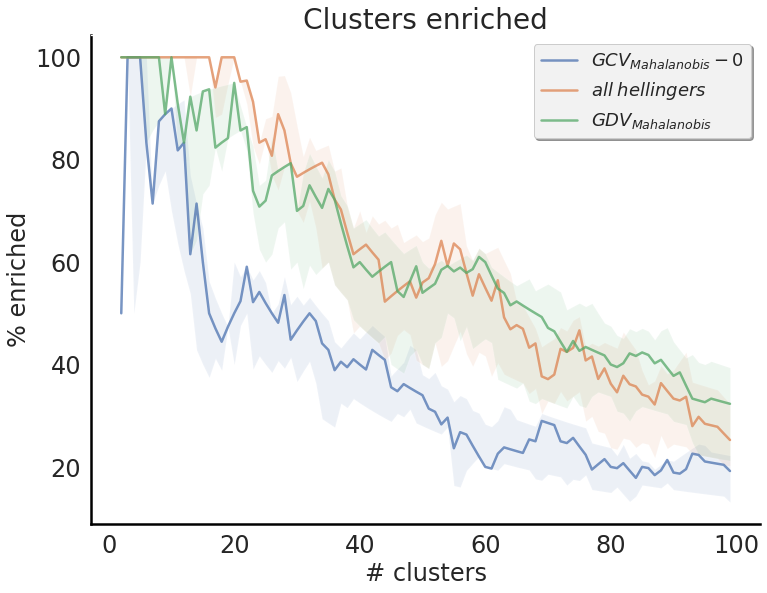

In [69]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for distance in plot_distances:
    ax.plot(range(2,MAX_CLUSTERS), 100*cluster_coverages[distance]['mc'], 
            label=f'${name2string[distance]}$', 
            linewidth=2.5,
            alpha=0.75);
    
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     100*cluster_coverages[distance]['hc'], 
                     100*cluster_coverages[distance]['lc'], 
                     alpha=0.1,);
    ax.set_title('Clusters enriched', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_cluster.png")

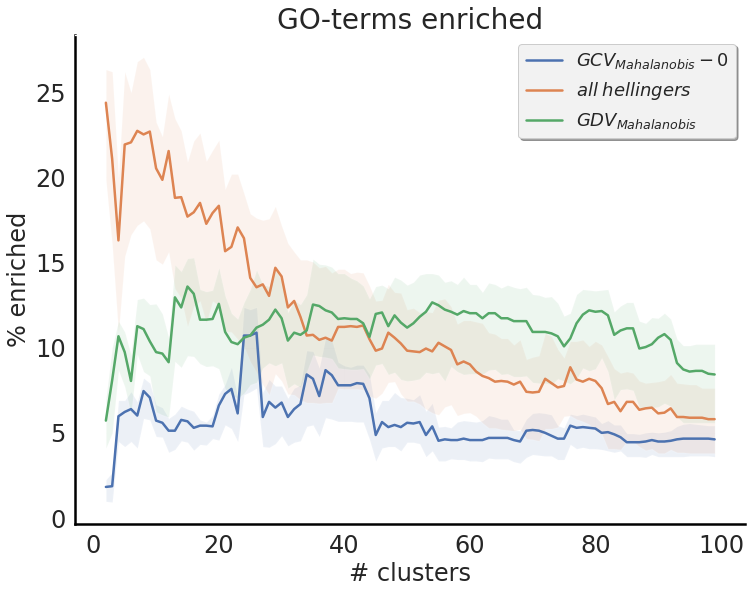

In [70]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

for distance in plot_distances:
    
    ax.plot(range(2,MAX_CLUSTERS), 100*GO_coverages[distance]['mc'], 
             label=f'${name2string[distance]}$', 
             linewidth=2.5);
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     100*GO_coverages[distance]['hc'], 
                     100*GO_coverages[distance]['lc'], 
                     alpha=0.1);
    ax.set_title('GO-terms enriched', fontsize=28)
    
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_go.png")

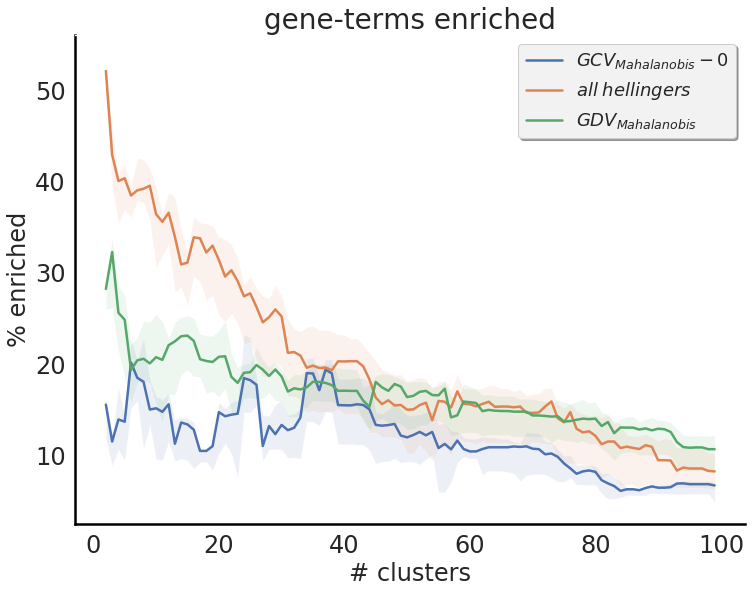

In [71]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

for distance in plot_distances:
    
    ax.plot(range(2,MAX_CLUSTERS), 100*gene_coverages[distance]['mc'], 
             label=f'${name2string[distance]}$', 
             linewidth=2.5);
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     100*gene_coverages[distance]['hc'], 
                     100*gene_coverages[distance]['lc'], 
                     alpha=0.1);
    ax.set_title('gene-terms enriched', fontsize=28)
    
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_gene.png")

# Test

In [16]:
p_values_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
GO:0006518,0.212222,0.444652,0.002369,0.033161,0.332357,1.000000,0.104190,1.0,0.240645,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,0.006103,0.967245,0.869226,0.167601,0.388479,0.226563,...,1.000000,1.000000,1.000000,1.000000,1.0,0.268052,1.000000,0.874227,0.914319,0.554955,0.474535,1.0,1.000000,0.091029,1.000000,1.000000,1.000000,0.413087,0.681011,1.000000,1.0,1.0,1.0,1.0,1.000000
GO:0010906,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.030018,1.0,1.000000,1.000000,1.000000,0.082808,1.000000,1.000000,0.044700,1.000000,1.0,1.000000,1.0,1.000000,0.854245,0.867170,1.000000,1.000000,1.000000,...,1.000000,0.002497,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.679870,0.200888,1.000000,1.0,0.004900,0.132818,1.000000,1.000000,1.000000,1.000000,1.000000,0.204967,1.0,1.0,1.0,1.0,1.000000
GO:0009063,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,0.902269,0.016041,1.000000,0.755202,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.149013,0.747268,0.237227,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.013289,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000
GO:0006357,0.221295,0.375070,0.478943,0.756444,0.186808,0.171409,0.005409,1.0,0.654330,0.015983,0.068285,0.325202,0.061495,0.008307,0.121763,1.000000,1.0,0.121763,1.0,1.000000,0.984280,0.999756,0.507302,0.195820,0.628929,...,0.559303,0.015983,0.321457,0.013663,1.0,1.000000,0.789651,0.501092,0.747984,0.000025,0.214059,1.0,1.000000,0.038624,0.789651,0.121763,0.677996,0.317613,0.246998,0.822892,1.0,1.0,1.0,1.0,0.246473
GO:0030838,1.000000,1.000000,1.000000,1.000000,1.000000,0.065100,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000147,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.375377,1.000000,1.000000,1.0,0.043173,1.000000,0.000909,1.000000,1.000000,0.059166,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0001731,1.000000,1.000000,1.000000,0.053239,1.000000,0.043870,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.030345,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000
GO:0001079,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.070425,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,0.628368,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.047895,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000
GO:0071940,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.066483,1.0,1.000000,1.0,1.000000,0.011734,0.689246,1.000000,1.000000,1.000000,...,1.000000,0.121090,1.000000,1.000000,1.0,1.000000,1.000000,0.248691,0.567314,1.000000,1.000000,1.0,0.165395,0.214325,1.000000,1.000000,1.000000,0.221081,0.098157,1.000000,1.0,1.0,1.0,1.0,1.000000
GO:0043409,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,0.548720,0.773572,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.00

In [28]:
len(population)

5538

In [20]:
with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/sc_BioGRID_all_hell_2.txt", 'r') as f:
    list_of_experiments = [set(line.split()) for line in f] 

clusters = dict(enumerate(list_of_experiments))

# For each GO term and cluster we get an experiment 
array_of_observed_successes = np.array([[len(draws & success_states) for draws in list_of_experiments]
                                    for success_states in list_of_success_states])



K = array_of_total_successes             # defined in section 'Preparation'
n = list(map(len, list_of_experiments))  # cluster lengths
k = array_of_observed_successes          # number of annotated genes found in cluster
N = sum(n)                               # PPI size, i.e. number of all genes that appear in a cluster

# scipy has a really messed up nomeclature... 
p_values_array = 1-hypergeom.cdf(k=k-1, M=N, N=n, n=K)
p_values_df    = pd.DataFrame(p_values_array, index=GO_population)
GO_index = p_values_df.index

m = p_values_array.size
enrichment_dfs = {confidence:get_enrichment_df(alpha,p_values_df) 
                          for confidence, alpha in confidences.items()}

In [21]:
N

5726